![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
# QuantConnect Alpha Streams
#### Licensed Under QuantConnect Platform Service Agreement v1.0. Copyright QuantConnect 2019.
#### For more information; see the Open API Specification of Alpha Streams: https://app.swaggerhub.com/apis/QuantConnect/Alpha/0.7

# Introduction

QuantConnect Alpha Streams allows quantitative funds to search a database of algorithms and instantly license the strategies (`Alphas`). The license agreements and fee structures are already prenegotiated, and the standardized backtesting and live trading infrastructure can give funds confidence in the algorithm results. The fund receives the insights/signals in realtime upon licensing an Alpha.

## User's Guide for Single Alpha Analysis

The Single Alpha Analysis notebook allows quantitative funds to quickly analyze the benefits of licensing a specific `Alpha` from QuantConnect Alpha Streams. Input a few custom parameters and get a quick summary of `Alpha` licensing risk and awards. Please follow the steps below and enjoy!

Step 1. Run the **'Appendix'** section at the end of this notebook

Step 2. Follow the **'Inputs'** section and customize your analysis

Step 3. Run the **'Report'** section to see the final results according to your inputs

# Inputs

1. Place your historical Net Asset Value data in csv format, and name the file 'NAV.csv'

In [2]:
FundNAV = 'NAV.csv'

2. Provide Alpha Properties

In [3]:
AlphaEquityCurve = 'RealAlpha_FullBacktest.csv'
AlphaListPrice = 3000
AlphaExclusiveListPrice = 10000

3. Provide Bid for Alpha (optional).

 QuantConnect's Alpha Markets allows you to bid for an alpha strategy. This price may be higher or lower than the asking price requested by the alpha author. Manually inputting your bid will change the price of the alpha strategy and generate a cost analysis that reflects your bid price.

In [4]:
AlphaBidPrice = 2500
AlphaExclusiveBidPrice = 5000

4. Set the fraction of capital allocated to Alpha. 

In [5]:
AlphaFraction = 0. #Example: 0.2 (20% of fund equity)

6. Set the start date and end date of the backtest

 If no input, the start date is assume to be the first day when alpha became available. The end date is the last day where data is availble in your fund NAV file.

In [6]:
StartDate = None
EndDate = None

# Report

#### Part I: Equity Curves Comparison
-  Key Definitions:
    - $\color{grey}{\text{Fund Cumulative Return}}$: the original equity curve of the fund
    - $\color{orange}{\text{Alpha Cumulative Return}}$: the equity curve of the target Alpha
    - $\color{black}{\text{Combined Cumulative Return}}$: the combined equity curve based on your capital allocation to the Alpha strategy
        
        
#### Part II: Performance Analysis
- Provides summary statistics of important fund performance metrics, which are derived from equity curve
- `Combined` provide the combined performance of the Alpha and fund strategies after allocating `AlphaStartingEquity` to the Alpha strategy
- `Change`: performance $\color{green}{\text{improvement}}$/$\color{red}{\text{deterioration}}$ from deploying the Alpha
    - Change = Combined results - Fund original results
    
    
#### Part III: Cost Analysis
- Key Definitions:
    - `Monthly Licensing Fee`: the price of the Alpha, or your bid price when applicable
    - `Average Monthly Net Profit`: the average monthly profit since inception
        - Profit is defined as the gain from deploying the Alpha, net of the Alpha's cost 
- Important：when licensing an uncorrelated Alpha through the fractional allocation approach, it might lead to a reduction in the fund’s absolute returns, but an improvement of the risk-adjusted returns. For this reason, we built a function to find the optimal leverage by matching the drawdown of fund’s original NAV. The fund can then see the impact of licensing this Alpha while maintaining the same risk appetite. The Average Monthly Net Profit is calculated based on this drawdown matching leverage.




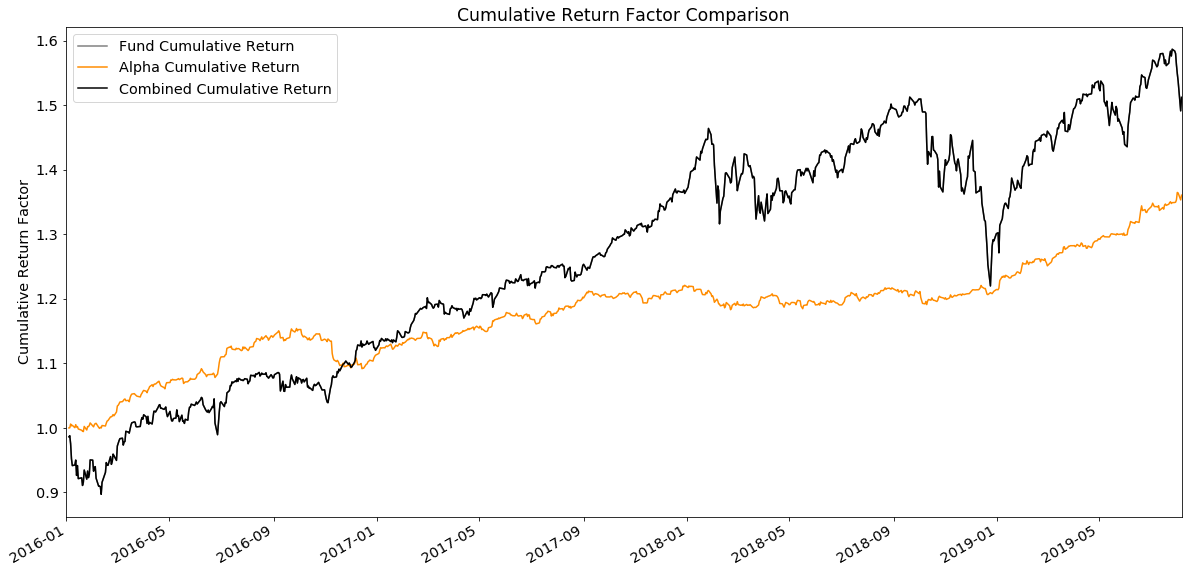

In [7]:
saa = SingleAlphaAnalysis(LoadCSV(FundNAV), LoadCSV(AlphaEquityCurve), AlphaFraction, AlphaBidPrice, AlphaExclusiveBidPrice, StartDate, EndDate)
saa.Run()

# Appendix: Import Libraries and Auxillary Functions

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML

class SingleAlphaAnalysis:
    def __init__(self, FundNAV, AlphaNAV, AlphaFraction, AlphaBidPrice, AlphaExclusiveBidPrice, StartDate, EndDate):
        self.alphaNAV = AlphaNAV
        self.fundNAV = FundNAV
        self.alphaFraction = AlphaFraction
        self.alphaBidPrice = AlphaBidPrice
        self.alphaExclusiveBidPrice = AlphaExclusiveBidPrice
        self.startDate = StartDate
        self.endDate=EndDate
        
        self.data = pd.concat([self.fundNAV, self.fundNAV.pct_change(),self.alphaNAV, self.alphaNAV.pct_change()], axis=1, join='inner')
        self.data.columns = ['FundNAV', 'FundReturn', 'AlphaNAV', 'AlphaReturn']
        
        # adjust the start and end date based on user's input
        if self.startDate is None:
            self.startDate = self.data.index[0]
        
        if self.endDate is None:
            self.endDate = self.data.index[-1]
            
        # Modify the self.data to only include information on applicable date
        self.data = self.data.loc[self.startDate:self.endDate,:]
        
        self.fundstartingequity = self.data['FundNAV'][0]
        self.alphaStartingEquity = AlphaFraction * self.fundstartingequity
        
        self.alphaStartDate = self.alphaNAV.index.to_pydatetime()[0]
        
        # adjust alpha prices based on bid
        if self.alphaBidPrice is not None:
            self.alphaPrice = self.alphaBidPrice
        else:
            self.alphaPrice = AlphaListPrice
            
        if self.alphaExclusiveBidPrice is not None:
            self.alphaExclusivePrice = self.alphaExclusiveBidPrice
        else:
            self.alphaExclusivePrice = AlphaExclusiveListPrice 

    def Run(self):
        params = {'legend.fontsize': 'x-large',
                          'figure.figsize': (20,10),
                          'axes.labelsize': 'x-large',
                          'axes.titlesize':'xx-large',
                          'xtick.labelsize':'x-large',
                          'ytick.labelsize':'x-large'}
        plt.rcParams.update(params)
    
        #Display Cumulative Return Factor Comparison according to User's Input Alpha Allocation
        colors = ['grey', 'darkorange','black']
        labels = ['Fund Cumulative Return','Alpha Cumulative Return','Combined Cumulative Return']
        titles = 'Cumulative Return Factor Comparison'
        df = self.Deploy(self.alphaStartingEquity)
        
        (df[['FundNAV','AlphaNAV','CombinedNAV']].pct_change()+1).cumprod().plot(color = colors,title = titles)
        plt.legend(labels)
        plt.ylabel('Cumulative Return Factor')
        plt.show()
        
        #Display Performance Analysis
        summary = self.CalculatePerformanceStats(df)
        self.DisplayPerformanceAnalysis(summary)
        
        #Display Cost Analysis
        cost = self.CalculateCost(df)
        self.DisplayCostAnalysis(cost)
                
        
    def Deploy(self, capitalallocation):
        df = self.data.copy()
        df['AlphaAllocation'] = capitalallocation

        for row in range(1,df.shape[0]):
            df.ix[row,'AlphaAllocation']=df.ix[row-1, 'AlphaAllocation']*(df.ix[row,'AlphaReturn']+1)
                
        df['FundAllocation'] = df['FundNAV'][0]-capitalallocation
        
        for row in range(1,df.shape[0]):
            df.ix[row,'FundAllocation']=df.ix[row-1, 'FundAllocation']*(df.ix[row,'FundReturn']+1)
        
        df['CombinedNAV']=df['AlphaAllocation']+df['FundAllocation']
        return df

    def CalculatePerformanceStats(self, deployment):
        summary = {}
        summary['Fund'] = self.Compute(deployment['FundNAV'])
        summary['Alpha'] = self.Compute(deployment['AlphaNAV'])
        summary['Combined'] = self.Compute(deployment['CombinedNAV'])
    
        summary = pd.DataFrame(summary)
        summary['Change'] = summary['Combined']-summary['Fund']
        return summary
    
    
    def VarianceMatchingLeverage(self, deployment):
        deployment['CombinedDailyReturn'] = deployment['CombinedNAV'].pct_change()
        deployment['LeveragedNAV'] = deployment['CombinedNAV']
        for leverage in np.arange(1.5,25.5,0.5): 
            for row in range(1,deployment.shape[0]):
                deployment.ix[row,'LeveragedNAV']=deployment.ix[row-1, 'LeveragedNAV']*(1+deployment.ix[row,'CombinedDailyReturn']*leverage)

            maxdrawdown_diff = self.MaxDD(deployment['LeveragedNAV'])-self.MaxDD(deployment['FundNAV'])

            if maxdrawdown_diff>0:

                return deployment
    
    def CalculateCost(self,deployment):
        costanalysis = {}
        
        leveraged_deployment = self.VarianceMatchingLeverage(deployment)

        costanalysis['Non-Exclusive']={'MonthlyCost': self.alphaPrice, 'AverageMonthlyNetProfit': self.AverageMonthlyNetProfit(leveraged_deployment)}
    
        costanalysis['Exclusive']={'MonthlyCost': self.alphaExclusivePrice, 'AverageMonthlyNetProfit': self.AverageMonthlyNetProfit(leveraged_deployment, True)}
        
        costanalysis = pd.DataFrame(costanalysis).T
        return costanalysis
    
    def AverageMonthlyNetProfit(self, deployment, exclusive = False):
        fund_monthly_pnl = []
        combined_monthly_pnl = []
        
        days_since_inception = (deployment.index[-1]-deployment.index[0]).days
        for i in range(int(days_since_inception/30)):
            LTM = deployment.loc[deployment.index[-1]-(i+1)*datetime.timedelta(days=30):deployment.index[-1]-i*datetime.timedelta(days=30),:]
            fund_monthly_pnl.append(LTM['FundNAV'][-1]-LTM['FundNAV'][0])
            if not exclusive:
                    combined_monthly_pnl.append(LTM['LeveragedNAV'][-1]-LTM['LeveragedNAV'][0]-self.alphaPrice)
            else:
                combined_monthly_pnl.append(LTM['LeveragedNAV'][-1]-LTM['LeveragedNAV'][0]-self.alphaExclusivePrice)
        
        result = np.mean(np.subtract(combined_monthly_pnl,fund_monthly_pnl))
        return result

    def Compute(self,ec):
        stat = pd.DataFrame(ec)
        stat['DailyReturn'] = stat.iloc[:,0].pct_change()
        self.days = (stat.index[-1]-stat.index[0]).days
        
        cum_return = ec[-1]/ec[0]-1
        cagr = (ec[-1]/ec[0])**(365/self.days)-1
        sharpe = self.Sharpe(ec)
        maxdrawdown = self.MaxDD(ec)
        romad = cum_return/maxdrawdown
        sortino = self.Sortino(ec)
       

        res = {'CAGR':cagr,
               'SharpeRatio': sharpe,
               'SortinoRatio': sortino,
               'MaxDrawdown':maxdrawdown}

        return res
    
    #code borrowed from https://stackoverflow.com/questions/22607324/start-end-and-duration-of-maximum-drawdown-in-python
    def MaxDD(self,ec):
        i = np.argmax(np.maximum.accumulate(ec) - ec) # end of the period
        j = np.argmax(ec[:i]) # start of period
        maxdd = abs((ec[i]-ec[j])/ec[j])

        return maxdd
    

    def Sharpe(self,ec):
        stat = pd.DataFrame(ec)
        stat['DailyReturn'] = stat.iloc[:,0].pct_change()

        #Sharpe Ratio Calculation need to incorporate risk-free
        r = stat['DailyReturn'].mean()
        s = stat['DailyReturn'].std()
        sharpe = (r/s)*np.sqrt(252)

        return sharpe
    
    def Sortino(self,ec):
        stat = pd.DataFrame(ec)
        stat['DailyReturn'] = stat.iloc[:,0].pct_change()
        
        target = 0
        stat['DownsideReturn']=0
        stat.loc[stat['DailyReturn']<target,'DownsideReturn'] = stat['DailyReturn']**2
        
        r = stat['DailyReturn'].mean()
        downside_s = np.sqrt(stat['DownsideReturn'].mean())
        sortino = (r/downside_s) * np.sqrt(252)
        
        return sortino
    
    def DisplayPerformanceAnalysis(self, summary):
        html = """<style type="text/css">
                .tg  {border-collapse:collapse;border-spacing:0;style="width:100%"}
                .tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 20px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-top-width:1px;border-bottom-width:1px;border-color:black;style="width:100%"}
                .tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 20px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-top-width:1px;border-bottom-width:1px;border-color:black;style="width:100%"}
                .tg .tg-gwxw{font-weight:bold;font-family:serif !important;;border-color:inherit;text-align:left;vertical-align:top}
                .tg .tg-idkv{font-weight:bold;font-family:serif !important;;background-color:#ffbd33;border-color:inherit;text-align:left;vertical-align:top}
                .tg .tg-t7yf{font-family:serif !important;;border-color:#000000;text-align:center;vertical-align:top}
                .tg .tg-gioa{font-weight:bold;font-family:serif !important;;border-color:inherit;text-align:center;vertical-align:top}
                .tg .tg-p78r{font-family:serif !important;;border-color:inherit;text-align:left;vertical-align:top}
                </style>
                <table class="tg" width="100%">
                  <tr>
                    <th class="tg-idkv" colspan="5">Performance Analysis</th>
                  </tr>
                  <tr>
                    <td class="tg-gwxw" colspan="1"></td>
                    <td class="tg-gioa">Alpha</td>
                    <td class="tg-gioa">Fund</td>
                    <td class="tg-gioa">Combined</td>
                    <td class="tg-gioa">Change</td>
                  </tr>
                  <tr>
                    <td class="tg-gwxw" colspan="1">Sharpe Ratio</td>
                    <td class="tg-t7yf">AlphaSharpe</td>
                    <td class="tg-t7yf">FundSharpe</td>
                    <td class="tg-t7yf">CombinedSharpe</td>
                    <td class="tg-t7yf" style="color: $$ChangeSharpeColor$$">ChangeSharpe</td>
                  </tr>
                  <tr>
                    <td class="tg-gwxw" colspan="1">Sortino Ratio</td>
                    <td class="tg-t7yf">AlphaSortino</td>
                    <td class="tg-t7yf">FundSortino</td>
                    <td class="tg-t7yf">CombinedSortino</td>
                    <td class="tg-t7yf" style="color: $$ChangeSortinoColor$$">ChangeSortino</td>
                  </tr>
                  <tr>
                    <td class="tg-gwxw" colspan="1">CAGR</td>
                    <td class="tg-t7yf">AlphaCAGR</td>
                    <td class="tg-t7yf">FundCAGR</td>
                    <td class="tg-t7yf">CombinedCAGR</td>
                    <td class="tg-t7yf" style="color: $$ChangeCAGRColor$$">ChangeCAGR</td>
                  </tr>
                  <tr>
                    <td class="tg-gwxw" colspan="1">Drawdown</td>
                    <td class="tg-t7yf">AlphaDrawdown</td>
                    <td class="tg-t7yf">FundDrawdown</td>
                    <td class="tg-t7yf">CombinedDrawdown</td>
                    <td class="tg-t7yf" style="color: $$ChangeDrawdownColor$$">ChangeDrawdown</td>
                  </tr>
                </table>"""

        
        html = html.replace("AlphaSharpe", str('{:.2f}'.format(summary.loc['SharpeRatio','Alpha'])))
        html = html.replace("FundSharpe", str('{:.2f}'.format(summary.loc['SharpeRatio','Fund'])))
        html = html.replace("CombinedSharpe", str('{:.2f}'.format(summary.loc['SharpeRatio','Combined'])))
        
        if float(summary.loc['SharpeRatio','Change']) >= 0 :
            html = html.replace("$$ChangeSharpeColor$$", "green")
            html = html.replace("ChangeSharpe", str('+{:.2f}'.format(summary.loc['SharpeRatio','Change'])))
        else :
            html = html.replace("$$ChangeSharpeColor$$", "red")
            html = html.replace("ChangeSharpe", str('{:.2f}'.format(summary.loc['SharpeRatio','Change'])))

        
        html = html.replace("AlphaSortino", str('{:.2f}'.format(summary.loc['SortinoRatio','Alpha'])))
        html = html.replace("FundSortino", str('{:.2f}'.format(summary.loc['SortinoRatio','Fund'])))
        html = html.replace("CombinedSortino", str('{:.2f}'.format(summary.loc['SortinoRatio','Combined'])))
        
        if float(summary.loc['SortinoRatio','Change']) >= 0 :
            html = html.replace("$$ChangeSortinoColor$$", "green")
            html = html.replace("ChangeSortino", str('+{:.2f}'.format(summary.loc['SortinoRatio','Change'])))
        else :
            html = html.replace("$$ChangeSortinoColor$$", "red")
            html = html.replace("ChangeSortino", str('{:.2f}'.format(summary.loc['SortinoRatio','Change'])))

            
        html = html.replace("AlphaDrawdown", str('{:,.2%}'.format(summary.loc['MaxDrawdown','Alpha'])))
        html = html.replace("FundDrawdown", str('{:,.2%}'.format(summary.loc['MaxDrawdown','Fund'])))
        html = html.replace("CombinedDrawdown", str('{:,.2%}'.format(summary.loc['MaxDrawdown','Combined'])))
        
        
        if float(summary.loc['MaxDrawdown','Change']) >= 0 :
            html = html.replace("$$ChangeDrawdownColor$$", "red")
            html = html.replace("ChangeDrawdown", str('+{:,.2%}'.format(summary.loc['MaxDrawdown','Change'])))
        else :
            html = html.replace("$$ChangeDrawdownColor$$", "green")
            html = html.replace("ChangeDrawdown", str('{:,.2%}'.format(summary.loc['MaxDrawdown','Change'])))
        
        
        
        html = html.replace("AlphaCAGR", str('{:,.2%}'.format(summary.loc['CAGR','Alpha'])))
        html = html.replace("FundCAGR", str('{:,.2%}'.format(summary.loc['CAGR','Fund'])))
        html = html.replace("CombinedCAGR", str('{:,.2%}'.format(summary.loc['CAGR','Combined'])))
        
        
        if float(summary.loc['CAGR','Change']) <= 0 :
            html = html.replace("$$ChangeCAGRColor$$", "red")
            html = html.replace("ChangeCAGR", str('{:,.2%}'.format(summary.loc['CAGR','Change'])))
        else :
            html = html.replace("$$ChangeCAGRColor$$", "green")
            html = html.replace("ChangeCAGR", str('+{:,.2%}'.format(summary.loc['CAGR','Change'])))
    
        display(HTML(html))
    
    def DisplayCostAnalysis(self, costanalysis):
        html = """<style type="text/css">
                .tg  {border-collapse:collapse;border-spacing:0;style="width:100%"}
                .tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 20px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-top-width:1px;border-bottom-width:1px;border-color:black;style="width:100%"}
                .tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 20px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-top-width:1px;border-bottom-width:1px;border-color:black;style="width:100%"}
                .tg .tg-gwxw{font-weight:bold;font-family:serif !important;;border-color:inherit;text-align:left;vertical-align:top}
                .tg .tg-idkv{font-weight:bold;font-family:serif !important;;background-color:#ffbd33;border-color:inherit;text-align:left;vertical-align:top}
                .tg .tg-t7yf{font-family:serif !important;;border-color:#000000;text-align:center;vertical-align:top}
                .tg .tg-gioa{font-weight:bold;font-family:serif !important;;border-color:inherit;text-align:center;vertical-align:top}
                .tg .tg-p78r{font-family:serif !important;;border-color:inherit;text-align:left;vertical-align:top}
                </style>
                <table class="tg" width="100%">
                  <tr>
                    <td class="tg-idkv" colspan="6">Cost Analysis</td>
                  </tr>
                  <tr>
                    <td class="tg-gwxw" colspan="2"></td>
                    <td class="tg-gioa" colspan="2">Non-Exclusive</td>
                    <td class="tg-gioa" colspan="2">Exclusive</td>
                  </tr>
                  <tr>
                    <td class="tg-gwxw" colspan="2">Monthly Licensing Fee</td>
                    <td class="tg-t7yf" colspan="2">$$Fee$$</td>
                    <td class="tg-t7yf" colspan="2">$$ExclusiveFee$$</td>
                  </tr>
                  <tr>
                    <td class="tg-gwxw" colspan="2">Average Monthly Net Profit</td>
                    <td class="tg-t7yf" style="color: $$AverageMonthlyNetProfitColor$$" colspan="2">$$AverageMonthlyNetProfit$$</td>
                    <td class="tg-t7yf" style="color: $$ExclusiveAverageMonthlyNetProfitColor$$" colspan="2">$$ExclusiveAverageMonthlyNetProfit$$</td>
                  </tr>
                </table>"""
        
        html = html.replace("$$Fee$$", '${:,.0f}'.format(costanalysis.loc['Non-Exclusive','MonthlyCost']))
        html = html.replace("$$ExclusiveFee$$", '${:,.0f}'.format(costanalysis.loc['Exclusive','MonthlyCost']))    
        
        if float(costanalysis.loc['Non-Exclusive','AverageMonthlyNetProfit']) <= 0 :
            html = html.replace("$$AverageMonthlyNetProfitColor$$", "red")
            html = html.replace("$$AverageMonthlyNetProfit$$", str('-${:,.0f}'.format(-costanalysis.loc['Non-Exclusive','AverageMonthlyNetProfit'])))
        else :
            html = html.replace("$$AverageMonthlyNetProfitColor$$", "green")
            html = html.replace("$$AverageMonthlyNetProfit$$", str('+${:,.0f}'.format(costanalysis.loc['Non-Exclusive','AverageMonthlyNetProfit'])))
        
        
        if float(costanalysis.loc['Exclusive','AverageMonthlyNetProfit']) <= 0 :
            html = html.replace("$$ExclusiveAverageMonthlyNetProfitColor$$", "red")
            html = html.replace("$$ExclusiveAverageMonthlyNetProfit$$", str('-${:,.0f}'.format(-costanalysis.loc['Exclusive','AverageMonthlyNetProfit'])))
        else :
            html = html.replace("$$ExclusiveAverageMonthlyNetProfitColor$$", "green")
            html = html.replace("$$ExclusiveAverageMonthlyNetProfit$$", str('+${:,.0f}'.format(costanalysis.loc['Exclusive','AverageMonthlyNetProfit'])))
       
        display(HTML(html))
        
    
def LoadCSV(filename):
    nav = pd.read_csv(filename, index_col =0)
    nav.columns = ['NAV']
    nav.index = pd.to_datetime(nav.index)
    return nav
    